# Практическое задание к уроку 7. Generative Adversarial Networks


1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции 

y=sin(x)/x-x/10

При выполнении данного задания структура GAN остается той же, но Вам нужно:

- Сгенерировать настоящие данные

- Изменить архитектуру дискриминатора и генератора

- Без графиков домашку не принимаю
	
    
2. (*Усложненное задание) Используя датасет MNIST из урока, построить модели генератора и дискриминатора в модели DCGAN как описано в оригинальной статье (https://arxiv.org/pdf/1511.06434.pdf). И обучите ее на данных MNIST. В качестве помощи, можете воспользоваться официальной статьей от pytorch (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#loss-functions-and-optimizers). 

#### 1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции

y=sin(x)/x-x/10

При выполнении данного задания структура GAN остается той же, но Вам нужно:

- Сгенерировать настоящие данные

- Изменить архитектуру дискриминатора и генератора

- Без графиков домашку не принимаю

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
# %%time

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device("cpu")
print(device)

cpu


In [4]:
def func_y(x):
    return np.sin(x)/x - x/10

train_data_x = np.linspace(-1,1,2048)
np.delete(train_data_x, 0)
train_data_y = func_y(train_data_x)
train_data = list(zip(train_data_x, train_data_y))
train_data = torch.tensor(train_data)

In [5]:
n_epochs = 200
batch_size = 32
lr = 0.0002

b1 = 0.5
b2 = 0.999

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.ReLU(0.2))
            return layers

        self.model = nn.Sequential(
            *block(8, 64),
            #*block(128, 256),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        return self.model(x)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.ReLU(0.2))
            return layers
        
        self.model = nn.Sequential(
            *block(2, 128),
            #*block(256, 128),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, x):
        return self.model(x)

In [9]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [10]:
d_loss_history = []
g_loss_history = []

In [11]:
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

sample_interval = 25

for epoch in range(n_epochs):
    for i, (data) in enumerate(train_loader):

# Лейблы для данных: 1 - настоящие, 0 - сгенерированные
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)  
        
        real_data = data.type(torch.FloatTensor).to(device)
# Тренировка генератора

        optimizer_G.zero_grad()
    
        #генерация шума
        noise = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 8))).to(device)

        generator_data = generator(noise)

        validity = discriminator(generator_data)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

# Тренировка дискриминатора

        optimizer_D.zero_grad()

        real_pred = discriminator(real_data)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(generator_data.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
# Отображение процесса обучения и вывод функций потерь
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            
           
                        
            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)
            
            display.clear_output(wait=False)
            #plt.clf()
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(train_data), d_loss.item(), g_loss.item()) ) 
            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            
            display.display(plt.gcf())
            #display.display()
            #plt.show()

# plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
# plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
# plt.legend(handles=[red_patch, green_patch])
# plt.show()

[Epoch 0/200] [Batch 0/2048] [D loss: 0.638818] [G loss: 0.720890]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

Так и не поняла как исправить ошибку

In [12]:
noise = torch.FloatTensor(np.random.normal(0, 1, (1000, 8))).to(device)
generated_data = generator(noise)
generated_data = generated_data.detach()
generated_data = generated_data.cpu().numpy()

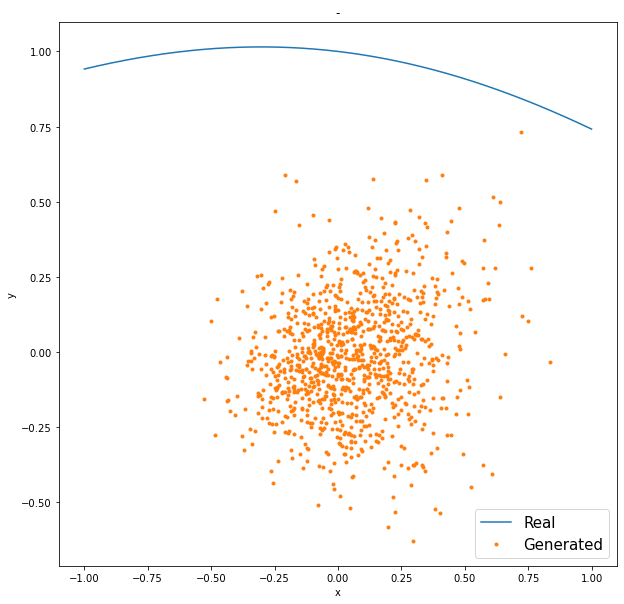

In [13]:
fig = plt.figure(figsize=(10, 10))

plt.plot(train_data[:, 0], train_data[:, 1], label='Real')
plt.plot(generated_data[:, 0], generated_data[:, 1], '.', label='Generated')

plt.xlabel('x')
plt.ylabel('y')
plt.title('-')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

#### 2. (*Усложненное задание) Используя датасет MNIST из урока, построить модели генератора и дискриминатора в модели DCGAN как описано в оригинальной статье (https://arxiv.org/pdf/1511.06434.pdf). 

И обучите ее на данных MNIST. 

В качестве помощи, можете воспользоваться официальной статьей от pytorch (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#loss-functions-and-optimizers).

In [14]:
# Функция для вывода и сохранения изображения

def sample_image(static_sample, epoch, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)

In [15]:
n_epochs = 20
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

In [16]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

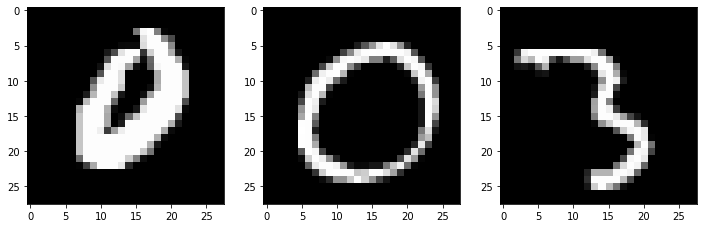

In [17]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

In [18]:
img_shape

(1, 28, 28)

In [19]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4 #=7
        
        # строим размер входного вектора 100 -> 7x7x128
        self.linear1 = nn.Sequential(nn.Linear(latent_dim, 64 * self.init_size ** 2),
                                     nn.ReLU(0.2),)

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(64, 64, (4, 4), stride=(2, 2), padding=1),            
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.8),
            nn.ConvTranspose2d(64, 1, (4, 4), stride=(2, 2), padding=1), 
            nn.Tanh()
        )

    def forward(self, noise):
        out = self.linear1(noise)

        out = out.view(out.shape[0], 64, self.init_size, self.init_size)
        
        img = self.conv(out)
        return img
    
generator = Generator().to(device)

print(generator)

Generator(
  (linear1): Sequential(
    (0): Linear(in_features=100, out_features=3136, bias=True)
    (1): ReLU(inplace=True)
  )
  (conv): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.8, inplace=False)
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)


In [20]:
z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)
gen_imgs = generator(z)
gen_imgs.shape

torch.Size([64, 1, 28, 28])

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.init_size = img_size // 4 # =7

        # Upsampling
        self.conv = nn.Sequential(nn.Conv2d(1, 32, 3, 2, 1), 
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.BatchNorm2d(32),
                                  nn.Conv2d(32, 64, 3, 2, 1), 
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.BatchNorm2d(64),
                                 )
        
        self.linear1 = nn.Sequential(nn.Linear(64 * self.init_size ** 2, 1),
                                     nn.Sigmoid())        

    def forward(self, img):
        out = self.conv(img)
        out = out.view(out.shape[0], -1)
        out = self.linear1(out)
        return out
    
    
discriminator = Discriminator().to(device)
    
print(discriminator)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Sequential(
    (0): Linear(in_features=3136, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [22]:
validity = discriminator(gen_imgs)
validity.shape

torch.Size([64, 1])

In [23]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [24]:
d_loss_history = []
g_loss_history = []

In [37]:
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

last_epoch = 0

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
# Лейблы для данных: 1 - настоящие, 0 - сгенерированные
    
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


# Тренировка генератора

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

# Тренировка дискриминатора

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
# Отображение процесса обучения и вывод функций потерь
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
             
            display.clear_output(wait=True)
            plt.clf()
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) )  
                
            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()
            sample_image(gen_imgs, epoch)
            display.display(plt.gcf())
            
            if epoch != last_epoch:
                last_epoch = epoch
                sample_image(gen_imgs, epoch, save_img=True)

AttributeError: 'Adam' object has no attribute 'grad'

Так и не поняла как исправить ошибку

In [35]:
from IPython.display import Image

for i in range(1, 20):        
    display(Image('images/%d.png' % i))

TypeError: 'module' object is not callable